# Our last method of taking the counts of each bigram won't scale at all. It will grow exponentionally. We're going to take an MLP approach

We're going to be following the approach of this 2003 paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf.

While this paper used a word level model, we'll be sticking to character level models, but with the same modeling approach.

The paper took a vocabulary of 17,000 words and associated a 30 element feature vector to each, embedding them in a 30 dimensional space. The idea is that words that have similar meanings may end up near eachother in this 30D space, and conversly words that are very different, should be very far from each other. (Note: the paper mentions feature size numbers of 30, 60 and 100 in their experiments).

The great power here is the ability to use 'closeness' within the embedding space to generalize broadly.



In [1]:
!git clone https://github.com/ef-p/NLP_0_Hero.git
%cd /content/NLP_0_Hero

Cloning into 'NLP_0_Hero'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 3), reused 14 (delta 2), pack-reused 0
Receiving objects: 100% (18/18), 948.09 KiB | 9.12 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/NLP_0_Hero


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words

words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# Build the "vocabulary" of characters and the mapping to and from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # string to int
itos = {i:s for s, i in stoi.items()} # int to string
print(stoi,'\n',itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} 
 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# Here's how we build the dataset
# this is the context length of how far back we're going to look to predict the next char.
block_size = 3 # here we're looking at the last 3 characters to guess the 4th.

X,Y = [], []
# just the first five words for now .
for w in words[:5]:
  #print(w)
  context = [0]*block_size # creates a list the size of block_size,
  for ch in w + '.':
    ix = stoi[ch] #what's the indx of the character ?
    X.append(context) # add the context, first list should be all '.'
    Y.append(ix) # the index to get the character from itos.
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    #the above prints the current context, --> and then the next letter

    context = context[1:] + [ix] # crop, and append the index for the next character.

X,Y = torch.tensor(X), torch.tensor(Y)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

**As you can see above we have 32 training examples that we made out of our first five names. Each of these examples is a triplet of charcters, made from our 27 possible characters. These are the triplets that appear when considering only the first five names, as we eventually use the entire dataset, we'll get more**

In [8]:

# here's our look up table.
# the paper takes its 17000 words and puts them in spaces as small as 30
# we'll start with a 2D space
# 27 rows for our characters, and two columns for the size of the feature space
C = torch.randn((27,2))

In [9]:
# here's one embedding
C[5]

tensor([-1.0853,  0.0642])

In [10]:
#index using lists

C[[5,6,7]]

tensor([[-1.0853,  0.0642],
        [-1.3417,  0.4200],
        [-1.3186,  0.4074]])

In [11]:
# we can feed it a  tensor
C[torch.tensor([5,6,7])]

tensor([[-1.0853,  0.0642],
        [-1.3417,  0.4200],
        [-1.3186,  0.4074]])

In [12]:
# we can even send the same index again and again
C[torch.tensor([5,6,7,7,7,7,7,7])]

tensor([[-1.0853,  0.0642],
        [-1.3417,  0.4200],
        [-1.3186,  0.4074],
        [-1.3186,  0.4074],
        [-1.3186,  0.4074],
        [-1.3186,  0.4074],
        [-1.3186,  0.4074],
        [-1.3186,  0.4074]])

In [13]:
C[X].shape # we can therefore embed all the ints in X with just C[X]
# lets look at the shape to get this right in our heads.

torch.Size([32, 3, 2])

So we have 32 entries, each 3 characters long (our context length). and now each of the characters is identified by a 2D vector embedding. Let's just prove this to our selves before moving on.

In [14]:
X[13,2] # lets pluck out a random int

tensor(1)

In [15]:
C[X][13,2] # if we've done this correctly we should get the embedding for that int

tensor([-0.5659, -0.4650])

Remember, these number values are really characters. So, to reiterate, if we've got everything straight here the embedding for X[32,2] aka the embedding for tensor(1), should be [0.5771, 0.3914]. So if we've done this right we would expect C[X][13,2] == C[1], the previously mentioned embedding.

In [16]:
C[1] #the value is the same! pytorch indexing is very handy

tensor([-0.5659, -0.4650])

In [17]:
 emb = C[X]

In [18]:
# lets make the hidden layer


W1 = torch.randn((6, 100)) # we have 2D embeddings, and we have 3 of them, hence the 6. # the number of neurons is up to us.
b1 = torch.randn(100)

Now, ideally we'd like to do the following matmul: `emb @ W1 + b1`. But these matrix dims don't work. We'll have to fix this so our tensors are the same rank.lets try anad make emb a `[32,6]` matrix.

In [20]:
#The 1 index (value of 3) in emb refers to our context length, the triplet of words we collceted
#we're going to use torch.cat to smush all these into vectors with 6 elements
#recall that each emebedding is a vector of size 2.
conemb1 = torch.cat([emb[:,0, :], emb[:,1, :], emb[:,2, :]])


this works fine, but this isn't generalizable unfortunatly, if we had a different context length, this won't work. Lets use unbind and use it on the 1st dimension, and it'll work no matter what context length we choose.

In [21]:
conemb2 = torch.cat(torch.unbind(emb,1),1)

This is okay, but we have an even more efficient solution.

the view function works more efficiently because it doesn't involve moving anything around in memory. The storage stays exactly the same (one big vector) but some internal attributes of the object will change so that it is 'interpreted' or 'viewed' differently when we use it.

 So these interal structures are making it so our vector is 'interpreted' as 32,3,2 , view can change this so it's 'viewed' as 32,6. As long as everything multiplies out to be the same, we're golden.

In [22]:
emb.view(32,6).shape

torch.Size([32, 6])

In [24]:
#now we can do our operation!
# The -1 asks pytorch to figure out what that dimension is
# if the second dimension is 6, it can see that well this other one must be 32, otherwise the vector length would be wrong.

h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # passing our operation through a tanh activation fun
h.shape


torch.Size([32, 100])

In [25]:
# second set of W and B

W2 = torch.randn(100,27)
b2 = torch.randn(27)

logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [29]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True) # normalize, now they're probs so every row sums to 1
prob.shape

torch.Size([32, 27])

In [35]:
 #lets get the average negative log loss
 loss = -prob[torch.arange(32), Y].log().mean()
 loss

tensor(17.1312)

We're going to use nn.functional's cross entropy function moving forward. Our old method was really inefficient under the hood and could in some cases behave poorly numerically speaking. If a logit is too large, it'll grow exponentially out of the range of our floating point numbers. Pytorch takes care of this under the hood by subtracting each logit by the highest value, so that our largest logit will only ever be 0.


In [36]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.1312)

# Putting it all together

In [46]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g) # each character will have a 2D embedding
W1= torch.randn((6, 100), generator=g) # 3 triplets of 2 = 6, the 6 elm vectors are fed through 100 neurons
b1 = torch.randn(100, generator=g) # one bias for every neuron
W2 = torch.randn((100,27), generator=g) # Second set of weights, giving us our logits for the 27 characters, for each entry(triplet)
b2 = torch.randn(27, generator=g) # bias for each of the last neurons
parameters= [C, W1, b1, W2, b2]


In [47]:
sum(p.nelement() for p in parameters) # how many parameters do we have total ?


3481

In [48]:
for p in parameters:
    p.requires_grad_(True) #don't forget! We need this to train

In [42]:
for __ in range(1000):
  #forward pass
  emb = C[X] # C is (27,2), X is (32,3) ---> emb is (32,3,2)
  h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,6)
  logits = h @ W2 + b2 # (32,27) Second layer
  loss = F.cross_entropy(logits, Y)
  #print(loss.item())

  #backward pass
  for p in parameters:
    p.grad = None # zero out so we don't accumulate past gradients
  loss.backward()

  #update
  for p in parameters:
    p.data += -0.1 * p.grad # learning rate for us to choose.

print(loss.item())

0.25609633326530457


We got our We have alot of parameters and not many examples so it's easy to overfit. We dont get to 0 exactly ( the [000] triplet can up to 4 different next labels in our dataset, so it'll still get some wrong)

## Run it again with the whole dataset:



In [82]:
block_size = 3 # here we're looking at the last 3 characters to guess the 4th.

X,Y = [], []
# just the first five words for now .
for w in words:
  #print(w)
  context = [0]*block_size # creates a list the size of block_size,
  for ch in w + '.':
    ix = stoi[ch] #what's the indx of the character ?
    X.append(context) # add the context, first list should be all '.'
    Y.append(ix) # the index to get the character from itos.
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    #the above prints the current context, --> and then the next letter

    context = context[1:] + [ix] # crop, and append the index for the next character.

X,Y = torch.tensor(X), torch.tensor(Y)



In [83]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g) # each character will have a 2D embedding
W1= torch.randn((6, 100), generator=g) # 3 triplets of 2 = 6, the 6 elm vectors are fed through 100 neurons
b1 = torch.randn(100, generator=g) # one bias for every neuron
W2 = torch.randn((100,27), generator=g) # Second set of weights, giving us our logits for the 27 characters, for each entry(triplet)
b2 = torch.randn(27, generator=g) # bias for each of the last neurons
parameters= [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad_(True) #don't forget! We need this to train

In [73]:
for __ in range(10):
  #forward pass
  emb = C[X] # C is (27,2), X is (32,3) ---> emb is (32,3,2)
  h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,6)
  logits = h @ W2 + b2 # (32,27) Second layer
  loss = F.cross_entropy(logits, Y)
  #print(loss.item())

  #backward pass
  for p in parameters:
    p.grad = None # zero out so we don't accumulate past gradients
  loss.backward()

  #update
  for p in parameters:
    p.data += -0.1 * p.grad # learning rate for us to choose.

print(loss.item())

11.051856994628906


## Minibatching and the learning rate

The idea behind minibatching is that taking a step every epoch really slows everything down. Instead of going through the whole training set to get the ideal gradient, we can break it up into batches, and take multiple steps within one epoch. We trade quality of the gradient, for quantity and we can get to the same(or a very similar) place much faster. Careful not to have too small a batch size, there's a point where all your little steps will start to introduce noise

The learning rate is a hyperparameter we can play with. too small a value and you might not traing quickly enough, too high a value can cause the learning to become unstable.

reset the code above as needed to run the training loop

In [84]:
lre = torch.linspace(-3, 0 , 1000) # we'll take a list of learning rates to go through
lrs =lrs = 10**lre

In [86]:
lri = []
lossi = [] #we'll track the stats for the rates

for i in range(1000):


  #minbatch construcct
  ix = torch.randint(0, X.shape[0], (32,))


  #forward pass
  emb = C[X[ix]] # batches of 32 at a time for each step
  h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,6)
  logits = h @ W2 + b2 # (32,27) Second layer
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  #backward pass
  for p in parameters:
    p.grad = None # zero out so we don't accumulate past gradients
  loss.backward()

  #update
  lr = lrs[i] # lets go through our different lrs
  for p in parameters:
    p.data += -lr * p.grad # learning rate for us to choose.

  # track stats
  lri.append(lre[i]) # exponent of the learning rate
  lossi.append(loss.item())

print(loss.item())

9.414894104003906


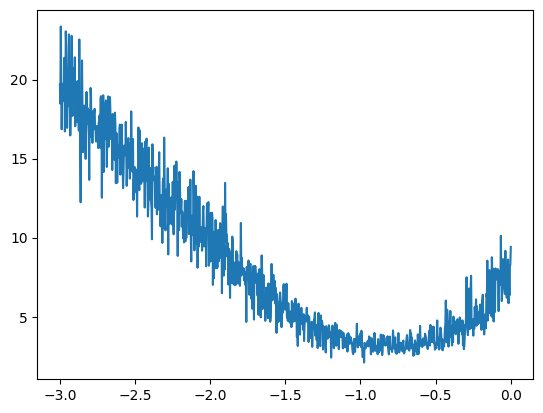

In [87]:
plt.plot(lri, lossi)

Our X axis is the exp of our learning rate. It looks like after $10^{-1}$ things get unstable. so a learning rate of 0.1 is probably our ideal learning rate.

You can retrain using $10^{-1}$ and consider decay the learning rate at the later stages of training

We should split our dataset into training, validation and test splits. Our model won't be very useful if it just memorizes verbatum that data it's seen.



*   Training Split ~ 80% of data: to train our network
*   Validation Split ~ 10 % of data: tune your hyperparameters
*   Test Split ~ 10% of data: evaluate the whole model

Always be precious about using the test split. It defeats the purpose if we over train on the test split.





